In [1]:
import warnings
#warnings.filterwarnings("ignore")
import scanpy as sc
import schist as scs
import pandas as pd
import scipy.stats
import sklearn.metrics
import scipy.spatial
import scipy.cluster

%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# nSBM hierarchy is consistent with differentiation trajectory

Here we show how nSBM hierarchy fits with known differentiation trajectory in hematopoietic development. We use data from Paul et al. 2015.

Data are retrieved using scanpy and processed as in PAGA how-to

In [2]:
sc.settings.verbosity=2
sc.set_figure_params(dpi=100, dpi_save=300)

In [3]:
adata = scs.io.read("../paul15_minimize")
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [4]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99556524 0.97735673 0.9709237  0.9515367  0.938553
     0.9337621  0.9230042  0.90864706 0.89296937 0.8787745  0.8683797
     0.8536444  0.84474975 0.8392589 ]
    finished (0:00:00)


In [5]:
n_neighbors = int(np.sqrt(adata.shape[0])/2)
print(n_neighbors)

26


In [7]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')


computing neighbors
    finished (0:00:00)


We define the root of differentiation in the 7MEP cluster

running PAGA
    finished (0:00:00)


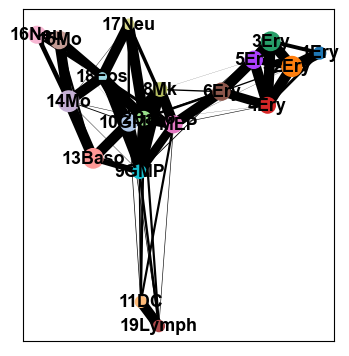

In [9]:
sc.tl.paga(adata, groups='paul15_clusters')

sc.pl.paga(adata, color=['paul15_clusters'])#, layout='rt_circular')

In [10]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished (0:00:24)


In [11]:
sc.set_figure_params(dpi_save=300, dpi=100)

In [12]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['paul15_clusters'] == '7MEP')[0]

In [13]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


Also, we calculate leiden clusters at increasing resolutions

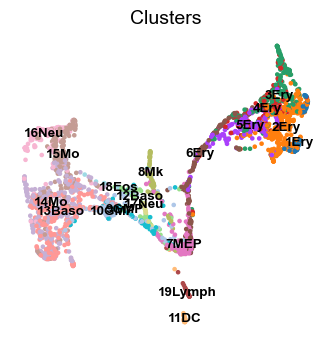

In [14]:
sc.pl.draw_graph(adata, color="paul15_clusters", frameon=False, 
                legend_loc='on data', legend_fontsize='x-small', 
                title='Clusters', save='paul15_original.png')

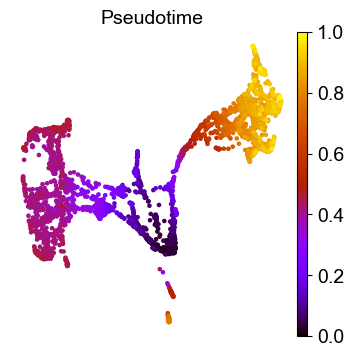

In [15]:
sc.pl.draw_graph(adata, color="dpt_pseudotime", frameon=False, 
                cmap='gnuplot',
                title='Pseudotime', save='paul15_dpt.png')

In [16]:
res_thr = np.linspace(1, .1, 10)
for x in res_thr:
    scs.inference.leiden(adata, resolution=x, key_added=f'leiden_r_{x:.1f}')

running Leiden clustering
    finished (0:00:32)
running Leiden clustering
    finished (0:00:21)
running Leiden clustering
    finished (0:00:25)
running Leiden clustering
    finished (0:00:31)
running Leiden clustering
    finished (0:00:28)
running Leiden clustering
    finished (0:00:25)
running Leiden clustering
    finished (0:00:25)
running Leiden clustering
    finished (0:00:20)
running Leiden clustering
    finished (0:00:19)
running Leiden clustering
    finished (0:00:23)


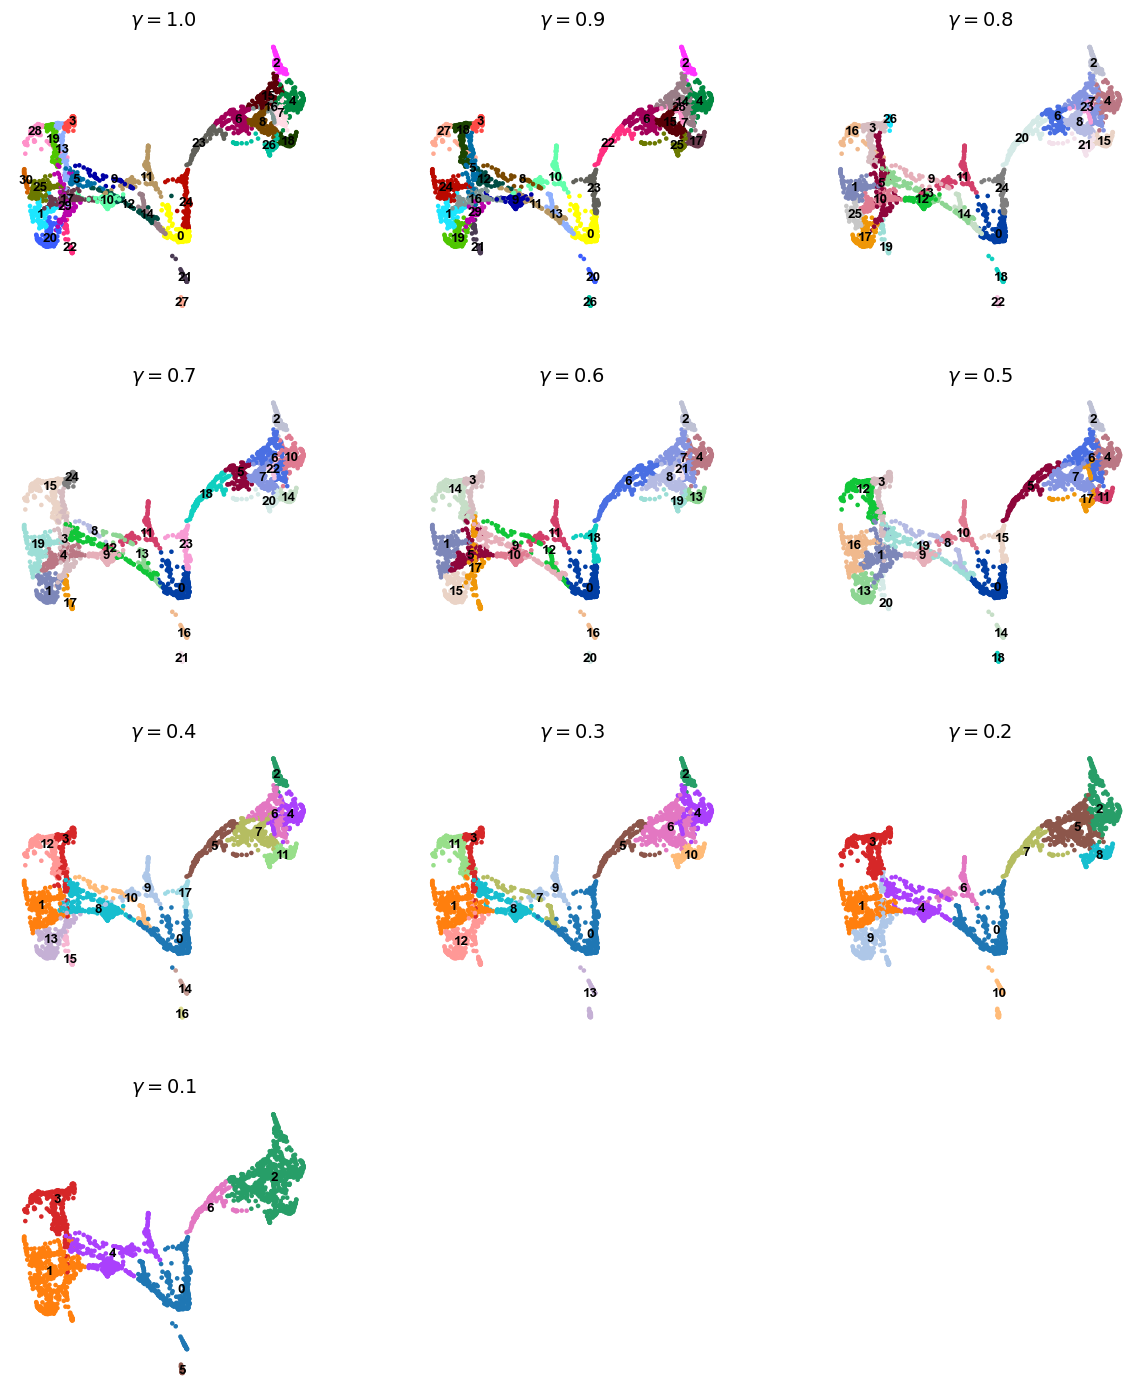

In [17]:
leiden_obs = [x for x in adata.obs_keys() if x.startswith('leiden')]
leiden_title = [x.replace('leiden_r_', '\gamma = ') for x in leiden_obs]
leiden_title = [f'${x}$' for x in leiden_title]
sc.pl.draw_graph(adata, color=leiden_obs, 
                 legend_loc='on data', ncols=3, frameon=False, 
                 legend_fontsize='x-small', title=leiden_title, 
                save='leiden_resolutions.png')

In [18]:
signatures = {
'Erythroids':['Gata1', 'Klf1', 'Epor', 'Gypa', 'Hba-a2', 'Hba-a1', 'Spi1'],
'Neutrophils':['Elane', 'Cebpe', 'Ctsg', 'Mpo', 'Gfi1'],
'Monocytes':['Irf8', 'Csf1r', 'Ctsg', 'Mpo'],
}

In [19]:
for s in signatures:
    sc.tl.score_genes(adata, gene_list=signatures[s], score_name=s)

computing score 'Erythroids'
    finished (0:00:00)
computing score 'Neutrophils'
    finished (0:00:00)
computing score 'Monocytes'
    finished (0:00:00)


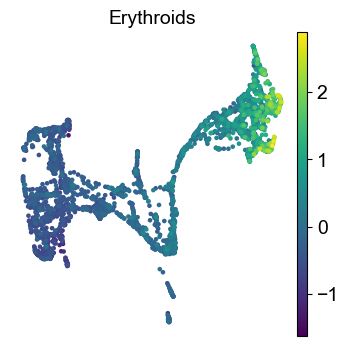

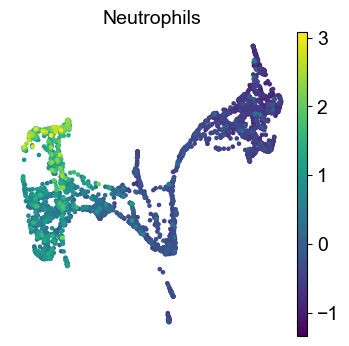

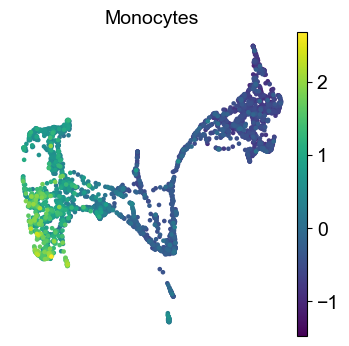

In [20]:
for c in ['Erythroids', 'Neutrophils', 'Monocytes']:
    sc.pl.draw_graph(adata, color=c, 
                 legend_loc='on data', frameon=False, 
                    save=f'signature_{c}.png')

In [21]:
backend = plt.get_backend()

minimizing the nested Stochastic Block Model
    done (0:06:54)
    finished (0:06:55)


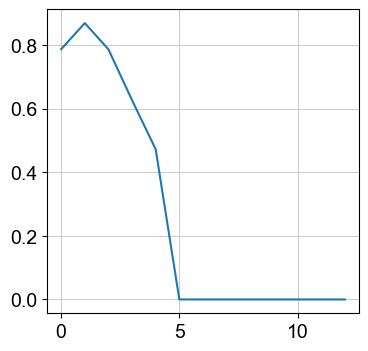

In [22]:
scs.inference.nested_model(adata, random_seed=1024)
plot(adata.uns['schist']['stats']['modularity'])

In [23]:
scs.io.write(adata, 'paul15')

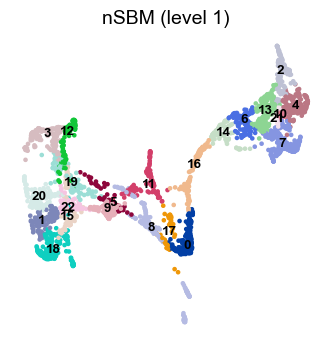

In [24]:
sc.pl.draw_graph(adata, color="nsbm_level_1", frameon=False, 
                legend_loc='on data', legend_fontsize='x-small', 
                title='nSBM (level 1)', save='paul15_nsbm_level_1.png')

In [3]:
adata = scs.io.read('paul15')

Look at pseudotime, how is in the embedding and on the tree

Text(0.5, 1.0, '')

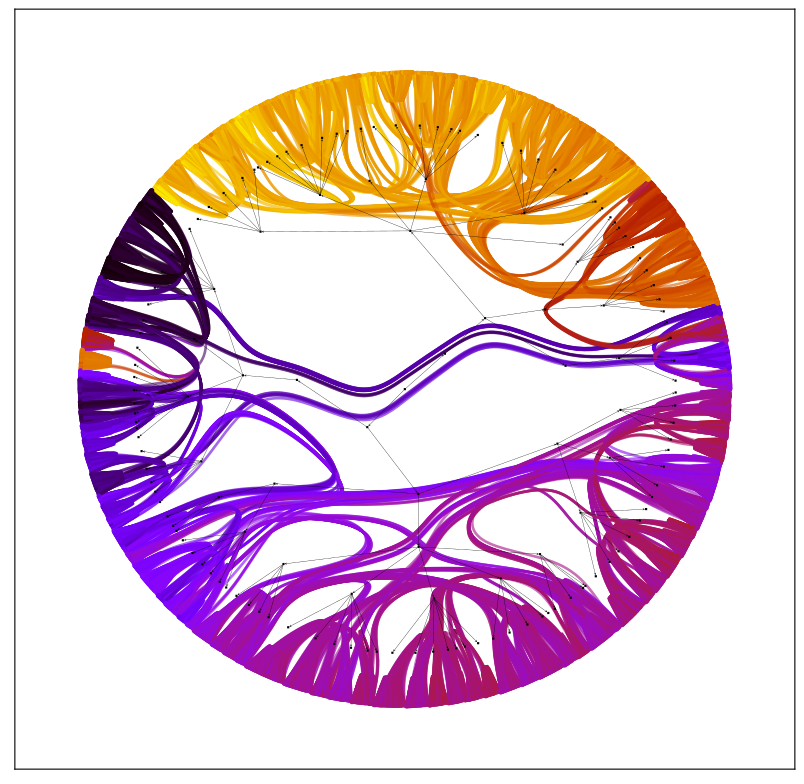

In [25]:
scs.pl.draw_tree(adata, color='dpt_pseudotime', color_map='gnuplot', save='tree_dpt.png')
title('')
#savefig('figures/tree_dpt.png', dpi=300)

Calculate signatures for the 3 main lieages, using known markers, then visualize

Text(0.5, 1.0, '')

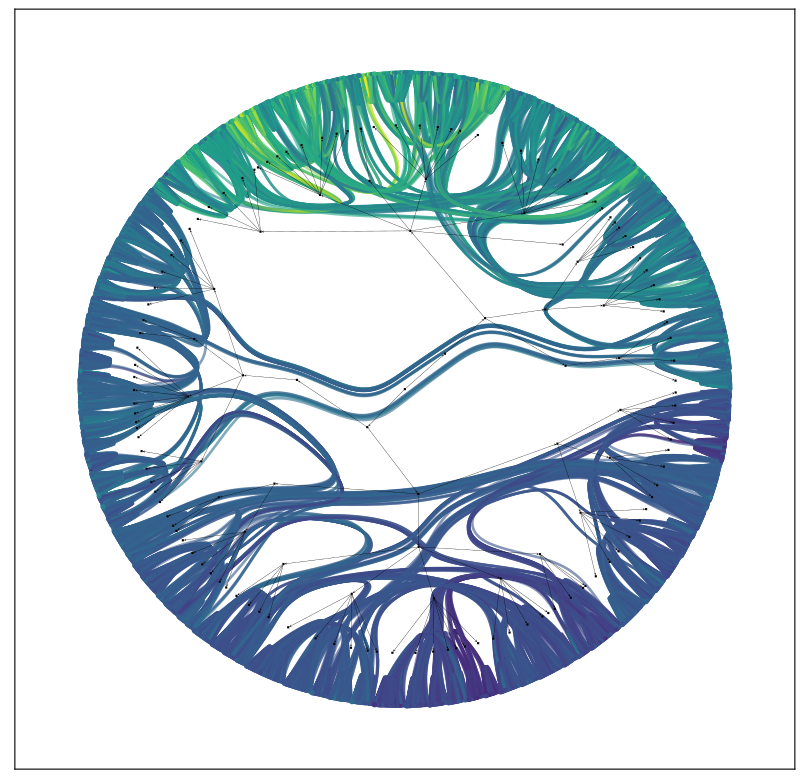

In [26]:
scs.pl.draw_tree(adata, color='Erythroids', save='tree_Erythroids.png')
title('')

Text(0.5, 1.0, '')

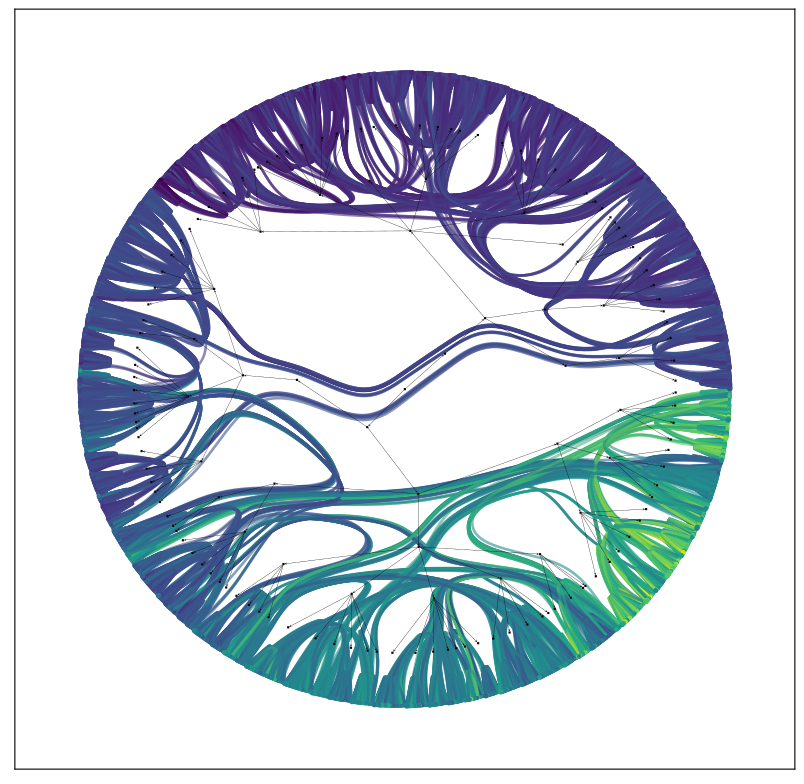

In [27]:
scs.pl.draw_tree(adata, color='Neutrophils', save='tree_Neutrophils.png')
title('')

Text(0.5, 1.0, '')

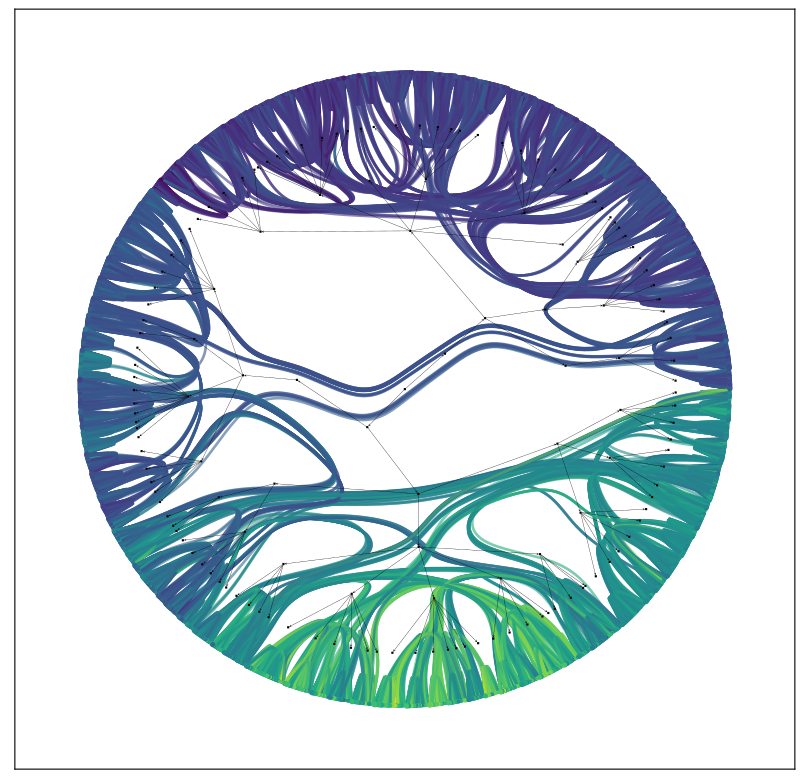

In [28]:
scs.pl.draw_tree(adata, color='Monocytes', save='tree_Monocytes.png')
title('')


Text(0.5, 1.0, '')

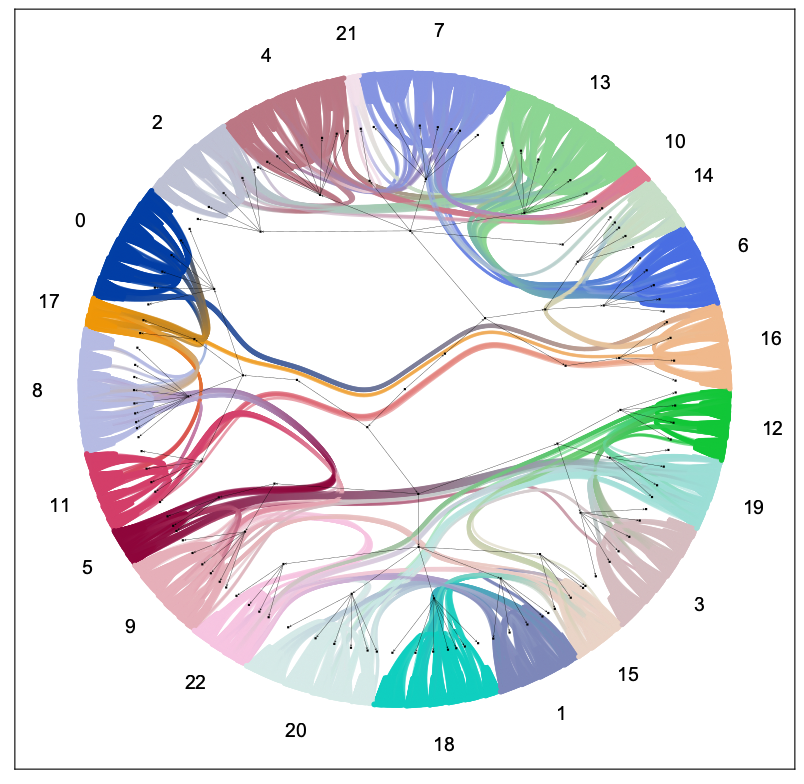

In [29]:
scs.pl.draw_tree(adata, level=1, save='tree_level_1.png')
title('')



Also, visualize all Leiden clusterings

Text(0.5, 1.0, '')

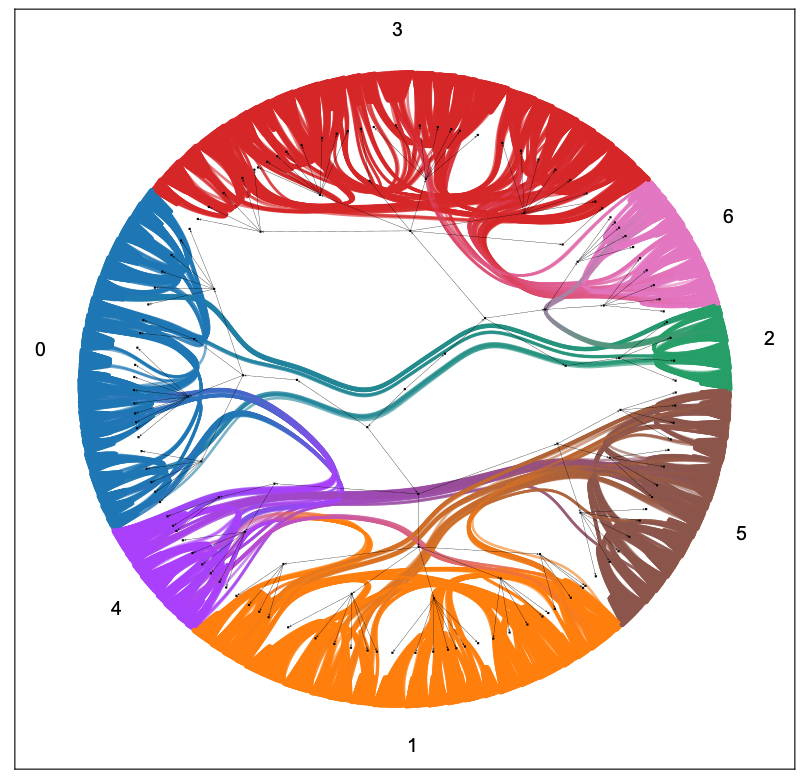

In [32]:
scs.pl.draw_tree(adata, level=2, save='tree_level_2.png')
title('')




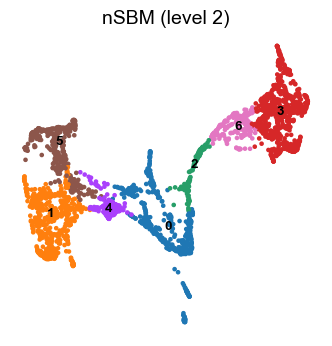

In [33]:
plt.switch_backend(backend)
sc.pl.draw_graph(adata, color="nsbm_level_2", frameon=False, 
                legend_loc='on data', legend_fontsize='x-small', 
                title='nSBM (level 2)', save='paul15_nsbm_level_2.png')

In [34]:
g = adata.uns['schist']['state'].g

In [35]:
g.num_vertices()

2730

In [39]:
scs.inference.planted_model(adata, random_seed=1024)

minimizing the Planted Partition Block Model
    done (0:02:53)
    finished (0:02:53)


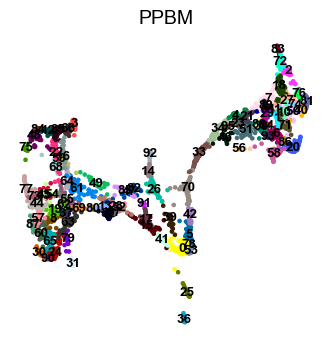

In [40]:
sc.pl.draw_graph(adata, color="ppbm", frameon=False, 
                legend_loc='on data', legend_fontsize='x-small', 
                title='PPBM', save='paul15_ppbm.png')

In [41]:
scs.io.write(adata, 'paul15_ppbm')

In [2]:
adata = scs.io.read("paul15")

In [4]:
sc.set_figure_params(dpi_save=300)

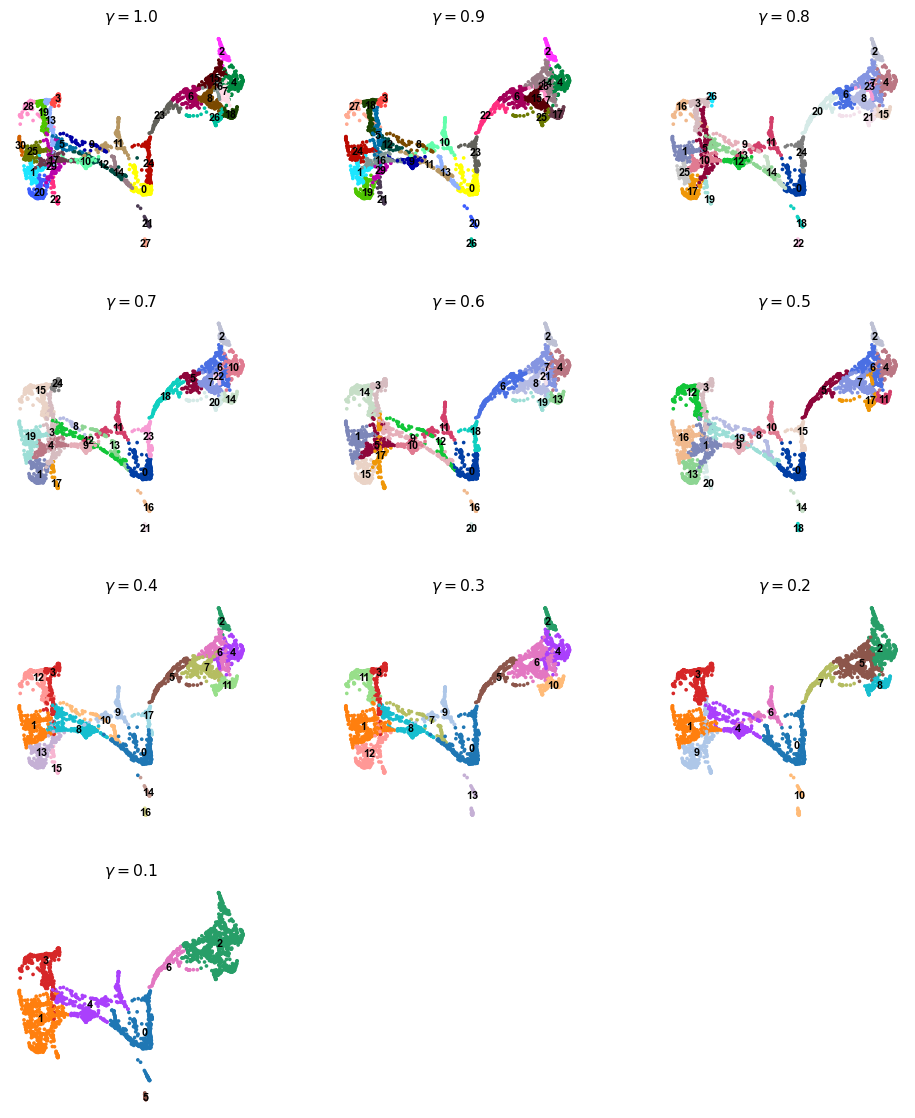

In [5]:
leiden_obs = [x for x in adata.obs_keys() if x.startswith('leiden')]
leiden_title = [x.replace('leiden_r_', '\gamma = ') for x in leiden_obs]
leiden_title = [f'${x}$' for x in leiden_title]
sc.pl.draw_graph(adata, color=leiden_obs, 
                 legend_loc='on data', ncols=3, frameon=False, 
                 legend_fontsize='x-small', title=leiden_title, 
                save='leiden_resolutions.pdf')

In [1]:
import warnings
#warnings.filterwarnings("ignore")
import scanpy as sc
import schist as scs
import pandas as pd
import scipy.stats
import sklearn.metrics
import scipy.spatial
import scipy.cluster

%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
backend = plt.get_backend()

In [3]:
plt.switch_backend(backend)

In [4]:
adata = scs.io.read("paul15")

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


In [5]:
sc.set_figure_params(dpi_save=300)

In [12]:
import graph_tool.all as gt

In [16]:
state = adata.uns['schist']['state']
g = state.g
fill_color = g.new_vertex_property('vector<double>')
g.vertex_properties['fill_color'] = fill_color

<ipython-input-43-d6821dc22ac7>:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  map_values = sklearn.preprocessing.MinMaxScaler().fit_transform(adata.obs[color][:, None]).ravel()
<ipython-input-43-d6821dc22ac7>:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  map_values = sklearn.preprocessing.MinMaxScaler().fit_transform(adata.obs[color][:, None]).ravel()
<ipython-input-43-d6821dc22ac7>:99: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  map_values = sklearn.preprocessing.MinMaxScaler().fit_transform(adata.obs[color][:, None]).ravel()


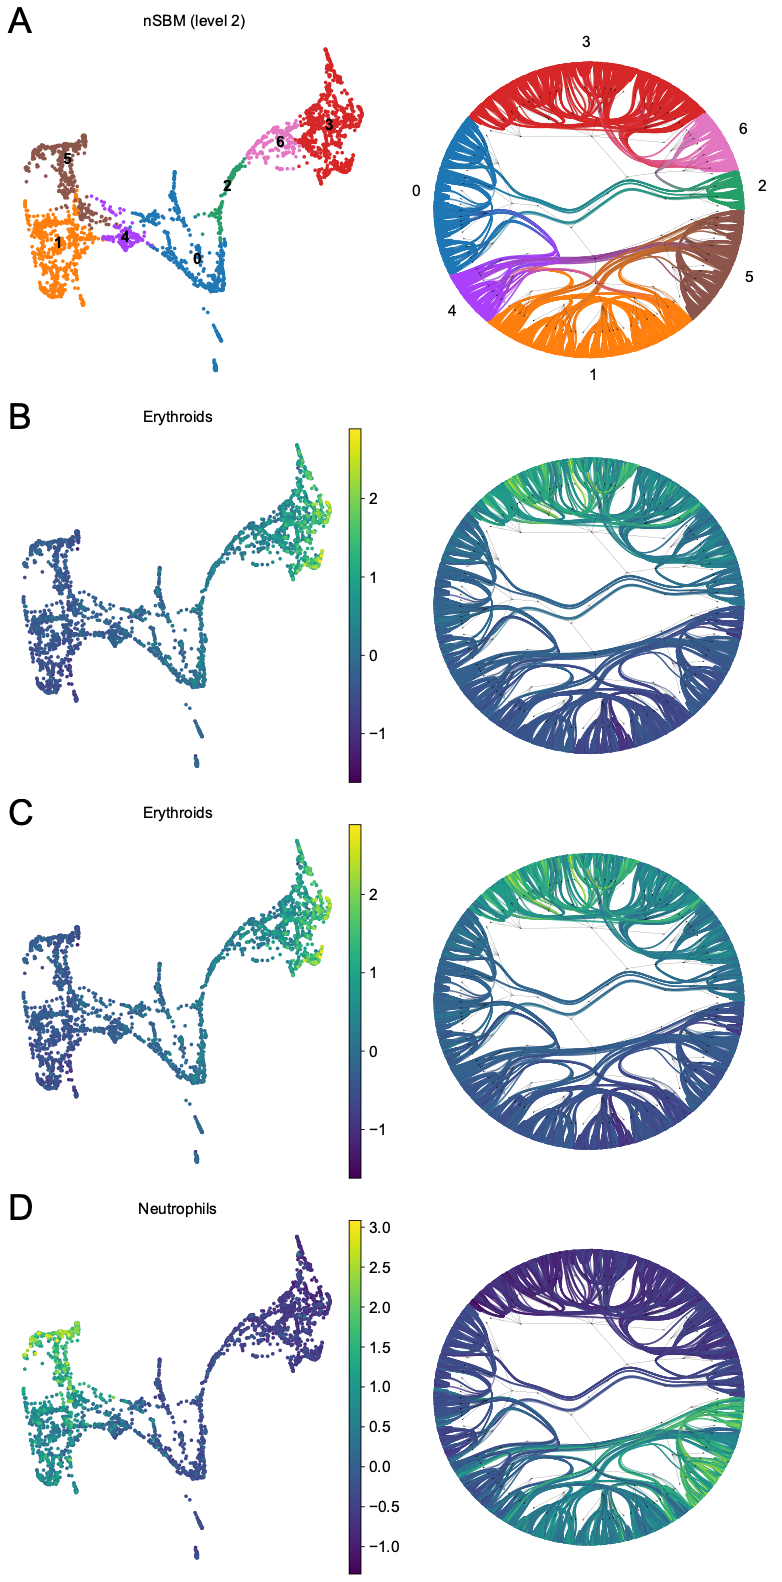

In [43]:
fig = figure(constrained_layout=False, figsize=(10, 20))
gs = fig.add_gridspec(4,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
color='nsbm_level_2'
sc.pl.draw_graph(adata, color=color, title='nSBM (level 2)', ax=ax1, show=False,
          frameon=False, legend_loc='on data')
ax1.text(0, 1, 'A', size=32, transform=ax1.transAxes)

adata_colors = adata.uns[f'{color}_colors']
categories = adata.obs[color].cat.categories
colors = [mpl.colors.to_rgba(x) for x in adata_colors]
colors = dict(zip(categories, colors))
node_color = [colors[x] for x in adata.obs[color]]
for v in range(len(node_color)):
    fill_color[v] = node_color[v]

pos, t, tpos = gt.draw_hierarchy(state,  
                                 vertex_fill_color=g.vertex_properties['fill_color'], 
                                vertex_color=g.vertex_properties['fill_color'],  
                                hedge_color=[0, 0, 0, 1], 
                                hvertex_fill_color=[0, 0, 0, 1],
                               mplfig=ax2)
coords = np.array([x for x in tpos])
state_len = np.array([len(x) for x in state.get_bs()])
dfc = pd.DataFrame(coords[:g.num_vertices()], index=adata.obs_names)
dfc = pd.concat([dfc, adata.obs[color]], axis=1)
g_coords = dfc.groupby(color).agg('mean').T
g_radius = np.sqrt(np.sum(g_coords**2, axis=0))
max_rx = g_radius.max() + .8
for group in g_coords.columns:
    text_p = g_coords[group] * max_rx / g_radius[group]
    ax2.text(text_p[0], text_p[1], f'{group}', 
            ha='center', va='center')


ax2.set_xticks([])
ax2.set_yticks([])
ax2.grid(False)
ax2.set_frame_on(False)
#######
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
color='Erythroids'
sc.pl.draw_graph(adata, color=color, ax=ax3, show=False,
          frameon=False, legend_loc='on data')
ax3.text(0, 1, 'B', size=32, transform=ax3.transAxes)

cmap = mpl.cm.get_cmap(plt.rcParams['image.cmap'])
map_values = sklearn.preprocessing.MinMaxScaler().fit_transform(adata.obs[color][:, None]).ravel()
node_color = cmap(map_values)
for v in range(len(node_color)):
    fill_color[v] = node_color[v]

pos, t, tpos = gt.draw_hierarchy(state,  
                                 vertex_fill_color=g.vertex_properties['fill_color'], 
                                vertex_color=g.vertex_properties['fill_color'],  
                                hedge_color=[0, 0, 0, 1], 
                                hvertex_fill_color=[0, 0, 0, 1],
                               mplfig=ax4)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.grid(False)
ax4.set_frame_on(False)
#######
ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])
coor='Monocytes'
sc.pl.draw_graph(adata, color=color, ax=ax5, show=False,
          frameon=False, legend_loc='on data')
ax5.text(0, 1, 'C', size=32, transform=ax5.transAxes)

cmap = mpl.cm.get_cmap(plt.rcParams['image.cmap'])
map_values = sklearn.preprocessing.MinMaxScaler().fit_transform(adata.obs[color][:, None]).ravel()
node_color = cmap(map_values)
for v in range(len(node_color)):
    fill_color[v] = node_color[v]

pos, t, tpos = gt.draw_hierarchy(state,  
                                 vertex_fill_color=g.vertex_properties['fill_color'], 
                                vertex_color=g.vertex_properties['fill_color'],  
                                hedge_color=[0, 0, 0, 1], 
                                hvertex_fill_color=[0, 0, 0, 1],
                               mplfig=ax6)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.grid(False)
ax6.set_frame_on(False)
#######
ax7 = fig.add_subplot(gs[3,0])
ax8 = fig.add_subplot(gs[3,1])
color='Neutrophils'
sc.pl.draw_graph(adata, color=color, ax=ax7, show=False,
          frameon=False, legend_loc='on data')
ax7.text(0, 1, 'D', size=32, transform=ax7.transAxes)

cmap = mpl.cm.get_cmap(plt.rcParams['image.cmap'])
map_values = sklearn.preprocessing.MinMaxScaler().fit_transform(adata.obs[color][:, None]).ravel()
node_color = cmap(map_values)
for v in range(len(node_color)):
    fill_color[v] = node_color[v]

pos, t, tpos = gt.draw_hierarchy(state,  
                                 vertex_fill_color=g.vertex_properties['fill_color'], 
                                vertex_color=g.vertex_properties['fill_color'],  
                                hedge_color=[0, 0, 0, 1], 
                                hvertex_fill_color=[0, 0, 0, 1],
                               mplfig=ax8)
ax8.set_xticks([])
ax8.set_yticks([])
ax8.grid(False)
ax8.set_frame_on(False)

plt.tight_layout()
plt.show()
fig.savefig('Figure_Hemato_Lineage.ps', dpi=300, transparent=True)



In [44]:
fig.savefig("Figure_Hemato_Lineage.pdf")

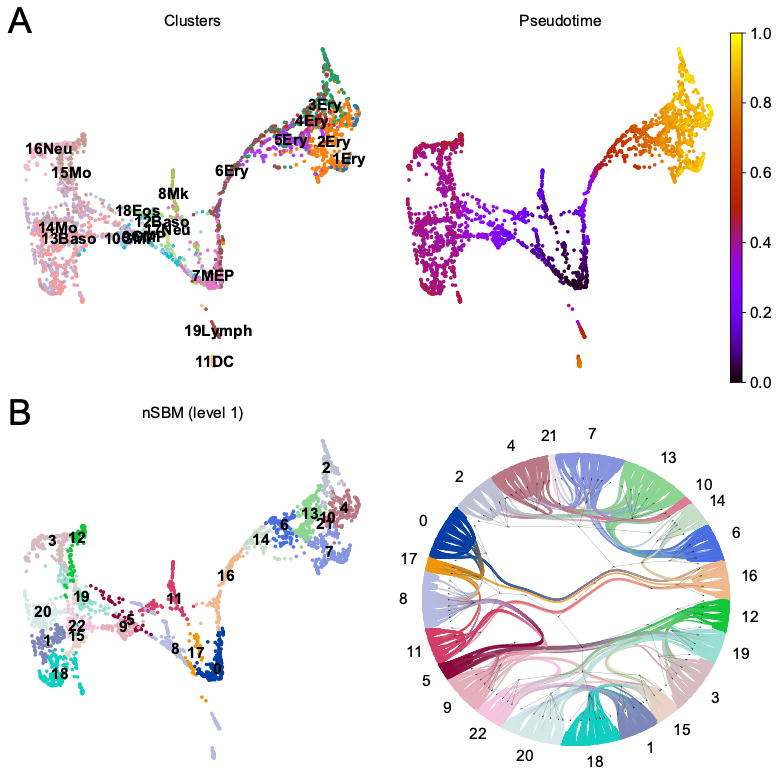

In [41]:
fig = figure(constrained_layout=False, figsize=(10, 10))
gs = fig.add_gridspec(2,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
sc.pl.draw_graph(adata, color='paul15_clusters', title='Clusters', ax=ax1, show=False,
          frameon=False, legend_loc='on data')
ax1.text(0, 1, 'A', size=32, transform=ax1.transAxes)
sc.pl.draw_graph(adata, color='dpt_pseudotime', title='Pseudotime', 
           ax=ax2, show=False,cmap='gnuplot',
          frameon=False, legend_loc='on data')


#######
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
color='nsbm_level_1'
sc.pl.draw_graph(adata, color=color, title='nSBM (level 1)', ax=ax3, show=False,
          frameon=False, legend_loc='on data')
ax3.text(0, 1, 'B', size=32, transform=ax3.transAxes)

adata_colors = adata.uns[f'{color}_colors']
categories = adata.obs[color].cat.categories
colors = [mpl.colors.to_rgba(x) for x in adata_colors]
colors = dict(zip(categories, colors))
node_color = [colors[x] for x in adata.obs[color]]
for v in range(len(node_color)):
    fill_color[v] = node_color[v]

pos, t, tpos = gt.draw_hierarchy(state,  
                                 vertex_fill_color=g.vertex_properties['fill_color'], 
                                vertex_color=g.vertex_properties['fill_color'],  
                                hedge_color=[0, 0, 0, 1], 
                                hvertex_fill_color=[0, 0, 0, 1],
                               mplfig=ax4)

coords = np.array([x for x in tpos])
state_len = np.array([len(x) for x in state.get_bs()])
dfc = pd.DataFrame(coords[:g.num_vertices()], index=adata.obs_names)
dfc = pd.concat([dfc, adata.obs[color]], axis=1)
g_coords = dfc.groupby(color).agg('mean').T
g_radius = np.sqrt(np.sum(g_coords**2, axis=0))
max_rx = g_radius.max() + .8
for group in g_coords.columns:
    text_p = g_coords[group] * max_rx / g_radius[group]
    ax4.text(text_p[0], text_p[1], f'{group}', 
            ha='center', va='center')


ax4.set_xticks([])
ax4.set_yticks([])
ax4.grid(False)
ax4.set_frame_on(False)


plt.tight_layout()
plt.show()
fig.savefig('Figure_Hemato_Supp.ps', dpi=300, transparent=True)




In [26]:
fig.savefig("foo.png")


In [27]:
fig.savefig("foo.ps")

In [42]:
fig.savefig("Figure_Hemato_Supp.pdf")

In [9]:
sc.pl.umap(adata, color='nsbm_level_2')

Text(0.5, 1.0, '')

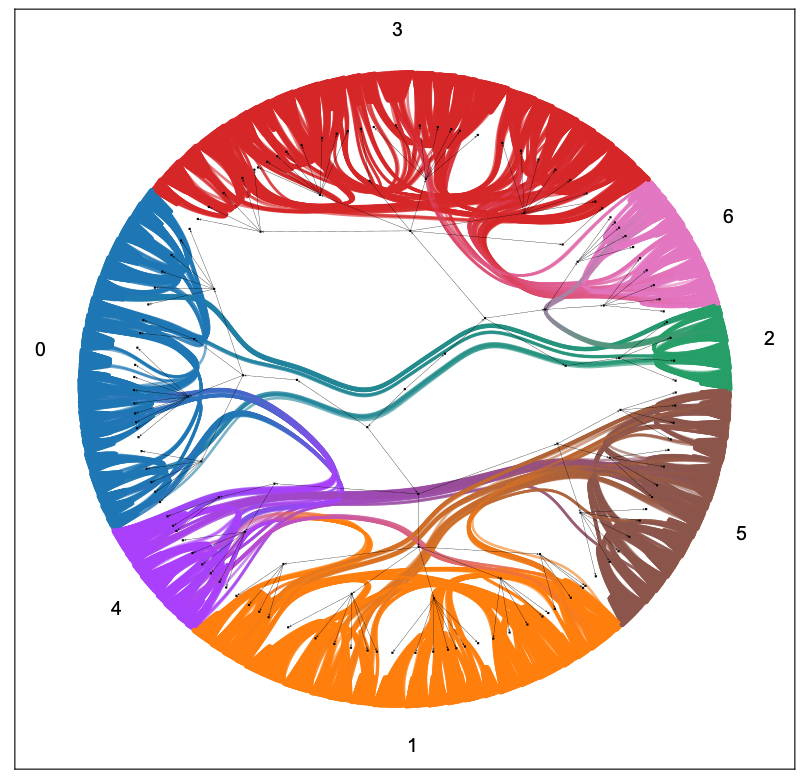

In [18]:
scs.pl.draw_tree(adata, level=2, save='tree_level_2.svg')
title('')

Text(0.5, 1.0, '')

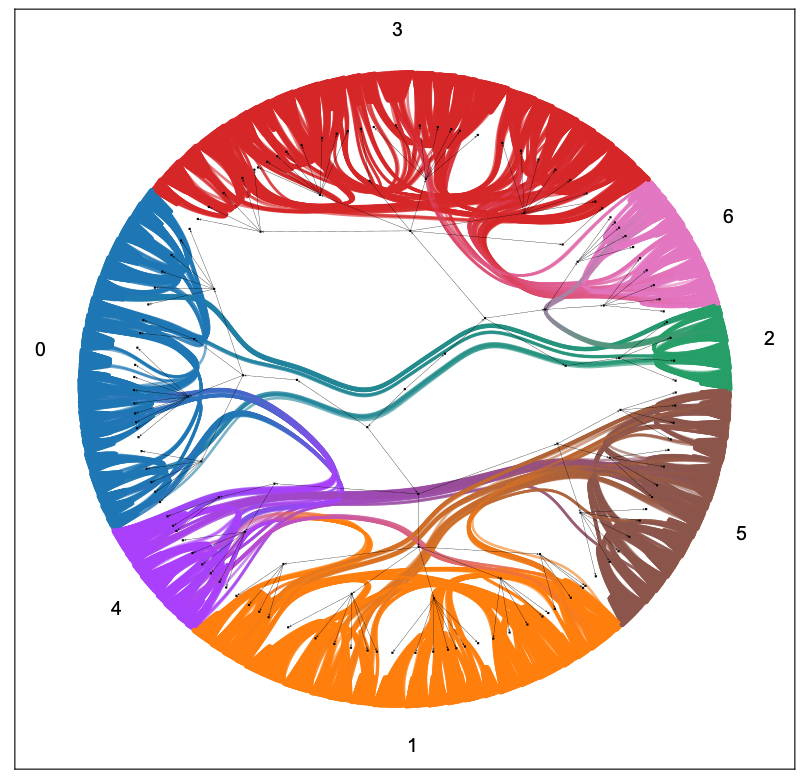

In [19]:
scs.pl.draw_tree(adata, level=2, save='tree_level_2.svg')
title('')

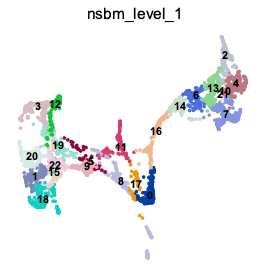

In [40]:
sc.pl.draw_graph(adata, color="nsbm_level_1", frameon=False, 
                legend_loc='on data', legend_fontsize='x-small')